# eQQMIX : Entangled Quantum QMIX Algorithm -- eQVDN

Multi-agent learning by deriving $Q_{tot}$ from GHZ-entangled agent PQCs and joint measurements.

Inspired by the tutorial: https://www.tensorflow.org/quantum/tutorials/quantum_reinforcement_learning#3_deep_q-learning_with_pqc_q-function_approximators

In [84]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [85]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import warnings
# warnings.filterwarnings('error', message=r".*complex128.*")
# warnings.simplefilter('module')

from silence_tensorflow import silence_tensorflow
silence_tensorflow()

from eqmarl import *
import pennylane as qml
import numpy as np
import functools as ft
import collections as cl
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
import gymnasium as gym
from pathlib import Path
from PIL import Image

In [86]:
# # Disable GPUs.
# tf.config.set_visible_devices([], 'GPU')

# List any available GPUs.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [87]:
# List information about PennyLane plugins.
qml.about()

Name: PennyLane
Version: 0.33.0
Summary: PennyLane is a Python quantum machine learning library by Xanadu Inc.
Home-page: https://github.com/PennyLaneAI/pennylane
Author: 
Author-email: 
License: Apache License 2.0
Location: /usr/local/Caskroom/miniforge/base/envs/qml/lib/python3.11/site-packages
Requires: appdirs, autograd, autoray, cachetools, networkx, numpy, pennylane-lightning, requests, rustworkx, scipy, semantic-version, toml, typing-extensions
Required-by: PennyLane-Cirq, PennyLane-Lightning

Platform info:           macOS-14.1.1-x86_64-i386-64bit
Python version:          3.11.6
Numpy version:           1.23.5
Scipy version:           1.11.3
Installed devices:
- default.gaussian (PennyLane-0.33.0)
- default.mixed (PennyLane-0.33.0)
- default.qubit (PennyLane-0.33.0)
- default.qubit.autograd (PennyLane-0.33.0)
- default.qubit.jax (PennyLane-0.33.0)
- default.qubit.legacy (PennyLane-0.33.0)
- default.qubit.tf (PennyLane-0.33.0)
- default.qubit.torch (PennyLane-0.33.0)
- default.q

In [88]:
from time import perf_counter
from contextlib import contextmanager

@contextmanager
def catchtime() -> float:
    start = perf_counter()
    yield lambda: perf_counter() - start


# with catchtime() as t:
#     import time
#     time.sleep(1)

# print(f"Execution time: {t():.4f} secs")

In [89]:
def one_qubit_rotation(qubit, symbols):
    """
    Returns Cirq gates that apply a rotation of the bloch sphere about the X,
    Y and Z axis, specified by the values in `symbols`.
    """
    return [cirq.rx(symbols[0])(qubit),
            cirq.ry(symbols[1])(qubit),
            cirq.rz(symbols[2])(qubit)]

def entangling_layer(qubits):
    """
    Returns a layer of CZ entangling gates on `qubits` (arranged in a circular topology).
    """
    cz_ops = [cirq.CZ(q0, q1) for q0, q1 in zip(qubits, qubits[1:])]
    cz_ops += ([cirq.CZ(qubits[0], qubits[-1])] if len(qubits) != 2 else [])
    return cz_ops

def generate_circuit_cirq(wires, n_layers):
    
    if isinstance(wires, int):
            wires = list(range(wires))
    elif isinstance(wires, (list, tuple)):
        wires = wires
    else:
        raise ValueError(f"Wires must either be an integer, list, or tuple; got {wires}")
    
    n_wires = len(wires)
    qubits = cirq.LineQubit.range(n_wires)
    
    
    ### Weights
    weights_var = sympy.symbols(f'theta(0:{3*(n_layers+1)*n_wires})')
    weights_var = np.asarray(weights_var).reshape((n_layers + 1, n_wires, 3))
    #
    weights_enc = sympy.symbols(f'x(0:{n_layers})'+f'_(0:{n_wires})')
    weights_enc = np.asarray(weights_enc).reshape((n_layers, n_wires))
    
    print(f"{weights_var.shape=}")
    print(f"{weights_enc.shape=}")
    
    circuit = cirq.Circuit()
    for l in range(n_layers):
        # Variational layer
        circuit += cirq.Circuit(one_qubit_rotation(q, weights_var[l, i]) for i, q in enumerate(qubits))
        circuit += entangling_layer(qubits)
        # Encoding layer
        circuit += cirq.Circuit(cirq.rx(weights_enc[l, i])(q) for i, q in enumerate(qubits))
    
    # Last varitional layer
    circuit += cirq.Circuit(one_qubit_rotation(q, weights_var[n_layers, i]) for i, q in enumerate(qubits))
    
    return circuit, (weights_var, weights_enc)


_, (cirq_weights_var, cirq_weights_enc) = generate_circuit_cirq(4, 5)

# class CirqQuantumLayer(keras.layers.Layer):
#     def __init__(self,
#         wires: int | list[int],
#         n_layers: int,
#         observables: list | Callable[[list], list] | None = None,
#         initial_state: list | Callable[[list], None] = None,
#         ):
#         super().__init__()
        
#         if isinstance(wires, int):
#             wires = list(range(wires))
#         elif isinstance(wires, (list, tuple)):
#             wires = wires
#         else:
#             raise ValueError(f"Wires must either be an integer, list, or tuple; got {wires}")
#         self.n_wires = len(wires)
#         self.wires = wires

weights_var.shape=(6, 4, 3)
weights_enc.shape=(5, 4)


In [90]:
device = qml.device('default.qubit')
@qml.qnode(device=device)
def quantum_circuit(wires, n_layers, observables, weights_var, weights_enc):
    VariationalEncodingPQC(
        weights_var=weights_var,
        weights_enc=weights_enc,
        n_layers=n_layers,
        wires=wires,
        )
    if observables is not None:
        res = [qml.expval(o) for o in observables]
        return res

class CustomQuantumLayer(keras.layers.Layer):
    def __init__(self,
        wires: int | list[int],
        n_layers: int,
        observables: list | Callable[[list], list] | None = None,
        initial_state: list | Callable[[list], None] = None,
        ):
        super().__init__()
        
        if isinstance(wires, int):
            wires = list(range(wires))
        elif isinstance(wires, (list, tuple)):
            wires = wires
        else:
            raise ValueError(f"Wires must either be an integer, list, or tuple; got {wires}")
        self.n_wires = len(wires)
        self.wires = wires
        
        self.set_observables(observables=observables)
        
        self.n_layers = n_layers
        self.initial_state = initial_state
        
        
        ### Create trainable variables for this layer.
        shape_weights_var, shape_weights_enc = VariationalEncodingPQC.shape(
            n_layers=n_layers,
            wires=wires,
            )
        print(f'got shape: {(shape_weights_var, shape_weights_enc)=}')
        
        self.weights_var = tf.Variable(
            initial_value=tf.random_uniform_initializer(minval=0., maxval=np.pi,)(shape=shape_weights_var, dtype='float32'),
            trainable=True,
            name='weights_var',
            )
        self.weights_enc = tf.Variable(
            initial_value=tf.ones(shape=shape_weights_enc, dtype='float32'),
            trainable=True,
            name='weights_enc',
            )
        print('init vars')
        
        ### Build quantum circuit.
        # self.q_device = qml.device('default.qubit', wires=wires)
        # self.q_qnode = qml.QNode(self.quantum_circuit, device=self.q_device)
        self.q_qnode = quantum_circuit
        print('build circuit')
        
        
    def call(self, inputs):
        
        inputs = tf.reshape(inputs, (-1, self.n_wires)) # Ensure shape is 2D with (batch, d_qubits)
        
        print('pre-einsum')
        weights_enc = tf.einsum("lqf,bq->blqf", self.weights_enc, inputs) # For each agent, encode each `input` state feature `q` on the `q-th` qubit and repeat encoding on same qubit for every layer `l`. Number of input features must match number of qubits.
        print('post-einsum')
        
        weights_var = self.weights_var
        
        print('pre-eval')
        # res = self.q_qnode(weights_var, weights_enc)
        res = self.q_qnode(self.wires, self.n_layers, self.observables, weights_var, weights_enc)
        print('post-eval')
        res = tf.convert_to_tensor(res) # Ensure tensor.
        res = tf.transpose(res) # Place batch dimension first.
        # new_shape = tf.concat([batch_dim, tf.shape(res)[1:]], axis=0)
        # res = tf.reshape(res, new_shape)
        return res

    def quantum_circuit(self, weights_var, weights_enc):
        VariationalEncodingPQC(
            weights_var=weights_var,
            weights_enc=weights_enc,
            n_layers=self.n_layers,
            wires=self.wires,
            )
        return self.measure()
    
    def measure(self) -> list | None:
        """Returns list of expectations across all observables."""
        if self.observables is not None:
            res = [qml.expval(o) for o in self.observables]
            return res
        
        
    def set_observables(self, observables: list | Callable[[list], list] | None = None):
        """Allows setting observables after circuit has been created."""
        if observables is None:
            self.observables = None
        elif hasattr(observables, '__iter__') and not isinstance(observables, str):
            self.observables = np.asarray(observables).tolist() # Ensure type is a Python list.
        elif isinstance(observables, Callable):
            self.observables = np.asarray(observables(self.wires)).tolist() # Ensure type is a Python list.
        else:
            raise ValueError(f"observables must either be a list or function; got `{observables}`")
        

In [91]:
class Rescaling(keras.layers.Layer):
    """Learnable rescaling from range [-1, 1] to range [0, 1]."""
    def __init__(self, input_dim):
        super().__init__()
        self.input_dim = input_dim
        self.w = tf.Variable(
            initial_value=tf.ones(shape=(1,input_dim)),
            dtype='float32',
            trainable=True,
            name='obs-weights',
            )
        
    def call(self, inputs):
        # inputs = tf.math.abs(inputs)
        # inputs = tf.cast(inputs, dtype='float32')
        return tf.math.multiply(
            (1+inputs)/2., # Rescale from [-1, 1] to range [0, 1].
            tf.repeat(self.w, repeats=tf.shape(inputs)[0], axis=0),
            )

In [92]:
def generate_model_Qlearning(n_wires, n_layers, observables, is_target):
    
    circuit = AgentCircuit(
        wires=n_wires,
        n_layers=n_layers,
        observables=observables,
    )
    # circuit = MARLCircuit(
    #     n_agents=1,
    #     d_qubits=4,
    #     n_layers=n_layers,
    #     observables=observables,
    #     # initial_state=lambda wires: entangle_agents_phi_plus(wires, d_qubits, n_agents),
    # )
    # qnode = circuit.qnode(device='lightning.gpu', interface='tf') # Set interface to TensorFlow.
    # tf_device_kwargs = dict(
    #     name='default.qubit.tf',
    #     tensorflow_device='cuda',
    # )
    # qnode = circuit.qnode(device=tf_device_kwargs, interface='tf', diff_method="backprop") # Set interface to TensorFlow.
    # qnode = circuit.qnode(device='default.qubit.tf', interface='tf', diff_method="backprop") # Set interface to TensorFlow.
    # qnode = circuit.qnode(device='lightning.qubit', interface='tf') # Set interface to TensorFlow.
    # qnode = circuit.qnode(device='default.qubit', diff_method="adjoint") # Set interface to TensorFlow.
    # qnode = circuit.qnode(device='default.qubit', interface='tf') # Set interface to TensorFlow.
    # qnode = circuit.qnode(device='cirq.simulator') # Set interface to TensorFlow.
    qnode = circuit.qnode(device='default.qubit.tf', interface='tf') # Set interface to TensorFlow.
    # qnode = circuit.qnode(device='cirq.simulator') # Set interface to TensorFlow.
    # qnode = circuit.qnode(device='lightning.qubit', interface=None) # Set interface to TensorFlow.
    
    # qnode = qml.transforms.broadcast_expand(qnode)
    
    qlayer = circuit.get_keras_layer(name='ReUploadingPQC', qnode=qnode)

    model = keras.Sequential([
            keras.Input(shape=(n_wires,), dtype=tf.dtypes.float32, name='input'), # Shape of model input, which should match the observation vector shape.
            qlayer,
            # CustomQuantumLayer(n_wires, n_layers, observables),
            # keras.layers.Lambda(lambda x: tf.math.abs(x)), # Convert complex to float via abs.
            keras.layers.Activation('tanh'), # Ensure outputs of PQC are in range [-1, 1].
            keras.Sequential([Rescaling(len(observables))], name=is_target*'Target'+'Q-values'),
        ],
        )
    return model
    

In [93]:
qml.device('cirq.simulator', wires=4).capabilities()

{'model': 'qubit',
 'tensor_observables': True,
 'supports_broadcasting': False,
 'supports_finite_shots': True,
 'supports_tensor_observables': True,
 'returns_probs': True,
 'returns_state': True}

In [94]:
def generate_model_Qlearning_MARL(n_agents, d_qubits, n_layers, observables, is_target):

    circuit = MARLCircuit(
        n_agents=n_agents,
        d_qubits=d_qubits,
        n_layers=n_layers,
        observables=observables,
        initial_state=lambda wires: entangle_agents_phi_plus(wires, d_qubits, n_agents),
    )
    qnode = circuit.qnode(interface='tf') # Set interface to TensorFlow.
    qlayer = circuit.get_keras_layer(name='MARL-ReUploadingPQCs', qnode=qnode)
    
    model = keras.Sequential([
            # Input shape must be 1D into the quantum layer, so use (n_agents, d_qubits,) followed by a reshape layer.
            keras.Input(shape=(n_agents, d_qubits,), dtype=tf.dtypes.float32, name='input'), # Shape of model input, which should match the combined observation vector shape for all agents.
            keras.layers.Reshape(target_shape=(-1,)), # Ensure input to the quantum layer is 1D for total number of wires.
            qlayer,
            # keras.layers.Lambda(lambda x: tf.math.abs(x)), # Convert complex to float via abs.
            keras.layers.Activation('tanh'), # Ensure outputs of PQC are in range [-1, 1].
            keras.Sequential([Rescaling(len(observables))], name=is_target*'Target'+'Q-values'),
        ],
        )
    return model, circuit
    

In [95]:
# env = gym.make('CartPole-v1')
n_actions = 2 # because `env.action_space.n == 2`
n_wires = 4 # because `env.observation_space.shape == (4,)`
# input_shape = (4,) # Shape of model input, which should match the observation vector shape `env.observation_space.shape == (4,)`

n_layers = 5 # Number of PQC layers.

observables = np.array([
    qml.PauliZ(wires=0) @ qml.PauliZ(wires=1), # Z0 Z1 (action 0 -- "left")
    qml.PauliZ(wires=2) @ qml.PauliZ(wires=3), # Z2 Z3 (action 1 -- "right")
    ])
# observables = lambda wires: [
#     qml.PauliZ(wires=0) @ qml.PauliZ(wires=1), # Z0 Z1 (action 0 -- "left")
#     qml.PauliZ(wires=2) @ qml.PauliZ(wires=3), # Z2 Z3 (action 1 -- "right")
#     ]

circuit = AgentCircuit(
    wires=n_wires,
    n_layers=n_layers,
    observables=observables,
)

# qnode = circuit.qnode(device='cirq.simulator')
# qnode = qml.transforms.broadcast_expand(qnode)

# print(qml.draw(qnode, wire_order=list(range(n_wires)))())

In [96]:
inputs = np.random.random(size=(16,4,))
CustomQuantumLayer(wires=4, n_layers=5, observables=observables)(inputs)

got shape: (shape_weights_var, shape_weights_enc)=((6, 4, 3), (5, 4, 1))


init vars
build circuit
pre-einsum
post-einsum
pre-eval
post-eval


<tf.Tensor: shape=(16, 2), dtype=float64, numpy=
array([[ 0.02244957, -0.15272183],
       [-0.39600534,  0.10686855],
       [-0.01517503,  0.13550406],
       [-0.43501235, -0.04501883],
       [-0.12202727, -0.04573747],
       [-0.33118969, -0.25787647],
       [-0.3487854 , -0.20212473],
       [-0.68281436,  0.029862  ],
       [-0.33301937, -0.08804562],
       [-0.25348182, -0.06584507],
       [-0.66484126,  0.33853128],
       [ 0.02177291,  0.22383502],
       [-0.51221907,  0.11221447],
       [-0.50826028,  0.06346768],
       [ 0.08330686,  0.3535901 ],
       [-0.49244223,  0.26614106]])>

In [97]:
model = generate_model_Qlearning(
    n_wires=n_wires,
    n_layers=n_layers,
    observables=observables,
    is_target=False,
    )

model_target = generate_model_Qlearning(
    n_wires=n_wires,
    n_layers=n_layers,
    observables=observables,
    is_target=True,
    )

print('setting weights')
model_target.set_weights(model.get_weights())

setting weights


In [98]:
# weights = model.layers[0].weights
# inputs = tf.convert_to_tensor(tf.constant(np.random.random(size=(16, 4,)), dtype='float32'))
# # inputs = [tf.convert_to_tensor(tf.constant(np.random.random(size=(4,)), dtype='float32')) for i in range(16)]

# # print(qml.draw(circuit, wire_order=list(range(circuit.n_wires)))(*weights, inputs))
# # circuit.qnode()(*weights, inputs)
# qnode(*weights, [b for b in inputs])

In [99]:
# tf.reduce_all(tf.reshape(tf.tile(weights[0], multiples=[16, 1, 1]), (16, 6, 4, 3))[0] == tf.reshape(tf.tile(weights[0], multiples=[16, 1, 1]), (16, 6, 4, 3))[-1])

In [100]:
# model(inputs)

In [101]:
observables_MARL = np.array([
    qml.PauliZ(wires=0) @ qml.PauliZ(wires=1) @ qml.PauliZ(wires=4) @ qml.PauliZ(wires=5), # Z0 Z1 Z4 Z5 (action 0 -- "left")
    # -(qml.PauliZ(wires=0) @ qml.PauliZ(wires=1) @ qml.PauliZ(wires=4) @ qml.PauliZ(wires=5)), # - Z0 Z1 Z4 Z5 (action 0 -- "left")
    qml.PauliZ(wires=2) @ qml.PauliZ(wires=3) @ qml.PauliZ(wires=6) @ qml.PauliZ(wires=7), # Z2 Z3 Z6 Z7 (action 1 -- "right")
    # -(qml.PauliZ(wires=2) @ qml.PauliZ(wires=3) @ qml.PauliZ(wires=6) @ qml.PauliZ(wires=7)), # - Z2 Z3 Z6 Z7 (action 1 -- "right")
    ])

model_MARL, circuit_MARL = generate_model_Qlearning_MARL(
    n_agents=2,
    d_qubits=4,
    n_layers=n_layers,
    observables=observables_MARL,
    is_target=False,
    )

# model_MARL.layers[0].weights[1].shape

# # Get shapes for weights of quantum layer.
# [w.shape for w in model.layers[0].weights]

In [102]:
# s = np.random.random(size=(3, 2, 4,))
# model_MARL([s])

In [103]:
model.get_layer('ReUploadingPQC').weights[0].shape, model.get_layer('ReUploadingPQC').weights[1].shape

(TensorShape([6, 4, 3]), TensorShape([5, 4, 1]))

In [104]:
model_MARL.get_layer('MARL-ReUploadingPQCs').weights[0].shape, model_MARL.get_layer('MARL-ReUploadingPQCs').weights[1].shape

(TensorShape([2, 6, 4, 3]), TensorShape([2, 5, 4, 1]))

In [105]:
# # Example override of MARL weights with weights from a local agent model.
# aidx = 0 # Agent index to update.
# updated_agents_weights_var = tf.stack([])
# updated_agents_weights_var = model_MARL.get_layer('MARL-ReUploadingPQCs').weights[0]
# # updated_agents_weights_var.scatter_update(model.get_layer('ReUploadingPQC').weights[0][:])
# # updated_agents_weights_var = tf.tensor_scatter_nd_update(updated_agents_weights_var, [[aidx, 6, 4, 3]], model.get_layer('ReUploadingPQC').weights[0])
# # updated_agents_weights_var[aidx].assign(model.get_layer('ReUploadingPQC').weights[0])
# # updated_agents_weights_enc = model_MARL.get_layer('MARL-ReUploadingPQCs').weights[1]
# # updated_agents_weights_enc[aidx].assign(model.get_layer('ReUploadingPQC').weights[1])
# # updated_agents_weights_enc
# updated_agents_weights_var
# # model_MARL.get_layer('MARL-ReUploadingPQCs').set_weights([updated_agents_weights_var, updated_agents_weights_enc])

In [106]:
# tf.reduce_all(model_MARL.get_layer('MARL-ReUploadingPQCs').get_weights()[aidx][0] == model.get_layer('ReUploadingPQC').weights[0])
# tf.reduce_all(model_MARL.get_layer('MARL-ReUploadingPQCs').get_weights()[aidx][1] == model.get_layer('ReUploadingPQC').weights[1])

In [107]:
# model_MARL.get_layer('MARL-ReUploadingPQCs').get_weights()[aidx][1].shape, model.get_layer('ReUploadingPQC').weights[1].shape

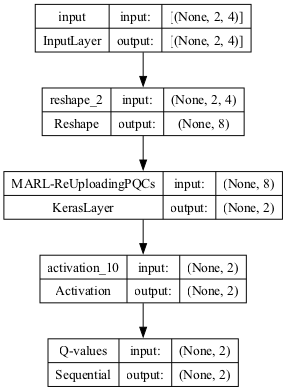

In [108]:
tf.keras.utils.plot_model(model_MARL, show_shapes=True, dpi=70, to_file="model_MARL.png")

(<Figure size 1200x900 with 1 Axes>, <Axes: >)

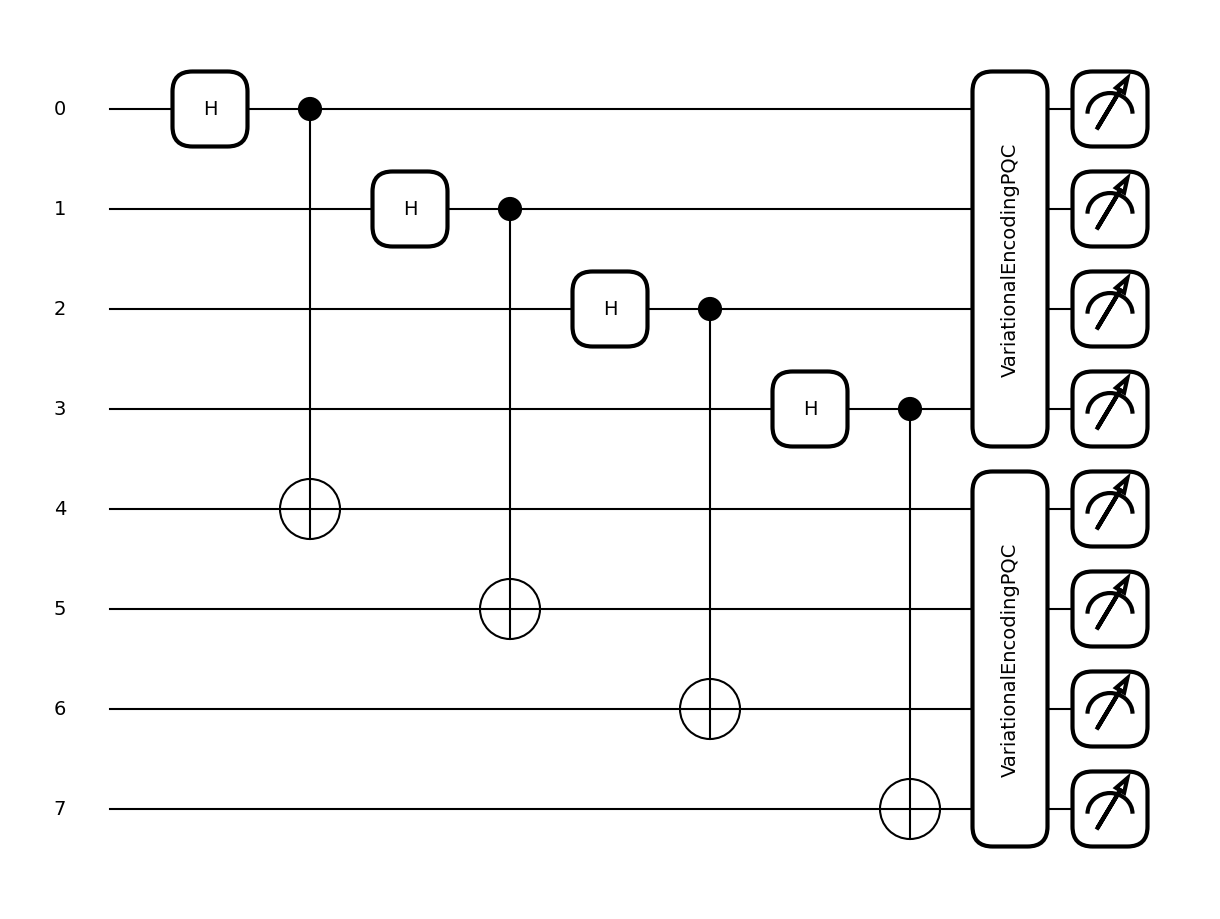

In [109]:
# print(qml.draw(circuit, wire_order=list(range(circuit.n_wires)))(*model.layers[0].weights))
qml.draw_mpl(circuit_MARL, wire_order=list(range(circuit.n_wires)))(*model_MARL.layers[1].weights)

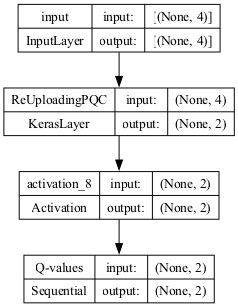

In [110]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=70, to_file="model_classic.png")

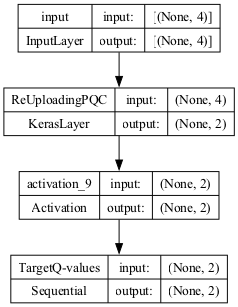

In [111]:
tf.keras.utils.plot_model(model_target, show_shapes=True, dpi=70, to_file="model_classic_target.png")

In [112]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ReUploadingPQC (KerasLayer)  (None, 2)                92        
                                                                 
 activation_8 (Activation)   (None, 2)                 0         
                                                                 
 Q-values (Sequential)       (None, 2)                 2         
                                                                 
Total params: 94
Trainable params: 94
Non-trainable params: 0
_________________________________________________________________


In [113]:
# ### Visualize the circuit.
# weight_shapes = circuit.weight_shapes
# weights = {
#     k: np.random.uniform(low=0., high=np.pi, size=s)
#     for k, s in weight_shapes.items()
# }
# # shape_var, shape_enc = circuit.shape
# # weights_var = np.random.uniform(low=0., high=np.pi, size=shape_var)
# # weights_enc = np.random.uniform(low=0., high=np.pi, size=shape_enc)
# print(qml.draw(circuit, wire_order=circuit.wires)(**weights))

In [114]:
def interact_env(state, model, epsilon, n_actions, env):
    # state_shape = state.shape
    # state = np.asarray(state).reshape((1, *state_shape)) # Reshape to (1, features) so that batch_size=1.
    # state = tf.convert_to_tensor([state]) # Reshape to (1, features) so that batch_size=1.
    state = np.asarray(state).reshape((1, 4)) # Reshape to (1, features) so that batch_size=1.
    
    # Select action.
    coin = np.random.random()
    if coin > epsilon: # Epsilon-greedy
        q_vals = model([state])
        action = int(tf.argmax(q_vals[0]).numpy())
    else: # Random action.
        action = np.random.choice(n_actions)
    
    next_state, reward, done, _, _ = env.step(action)
    next_state = np.asarray(next_state).reshape(state.shape)
    
    return dict(
        state=state,
        action=action,
        reward=reward,
        next_state=next_state,
        done=done,
    )

In [115]:
gamma = 0.99
n_episodes = 2000

# Define replay memory
max_memory_length = 10000 # Maximum replay length
replay_memory = cl.deque(maxlen=max_memory_length)

epsilon = 1.0  # Epsilon greedy parameter
epsilon_min = 0.01  # Minimum epsilon greedy parameter
decay_epsilon = 0.99 # Decay rate of epsilon greedy parameter
batch_size = 16
steps_per_update = 10 # Train the model every x steps
steps_per_target_update = 30 # Update the target model every x steps

optimizer_in = tf.keras.optimizers.Adam(learning_rate=0.001, amsgrad=True)
optimizer_var = tf.keras.optimizers.Adam(learning_rate=0.001, amsgrad=True)
optimizer_out = tf.keras.optimizers.Adam(learning_rate=0.1, amsgrad=True)

# Assign the model parameters to each optimizer
w_in, w_var, w_out = 1, 0, 2

optimizer_w_tups = list(zip([optimizer_in, optimizer_var, optimizer_out], [w_in, w_var, w_out]))

In [116]:
### Q-learning update function.

# @tf.function
def Q_learning_update(states, actions, rewards, next_states, done, model, model_target, gamma, n_actions, optimizer_w_tups):
    
    states = tf.convert_to_tensor(states)
    actions = tf.convert_to_tensor(actions)
    rewards = tf.convert_to_tensor(rewards)
    next_states = tf.convert_to_tensor(next_states)
    done = tf.convert_to_tensor(done)

    # Compute target Q-values and masks on sampled actions.
    # with catchtime() as t:
    future_rewards = model_target([next_states])
    target_q_values = rewards + (gamma * tf.reduce_max(future_rewards, axis=1) * (1. - done))
    # print(f"{target_q_values=}")
    # print(f"[target_q_values] Execution time: {t():.4f} secs")
    
    masks = tf.one_hot(actions, n_actions)
    # print(f"{actions=}")
    # print(f"{masks=}")
    
    
    # with catchtime() as t:
    # Train the model using target Q-values.
    with tf.GradientTape() as tape:
        tape.watch(model.trainable_variables)
        # with catchtime() as t1:
        q_values = model([states])
        # print(f"[tape:eval] Execution time: {t1():.4f} secs")
        # print(f"{q_values=}")
        q_values_masked = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
        # print(f"{q_values_masked=}")
        loss = tf.keras.losses.Huber()(target_q_values, q_values_masked)
    # print(f"[tape] Execution time: {t():.4f} secs")
        
    # with catchtime() as t:
    # Backprop.
    grads = tape.gradient(loss, model.trainable_variables)
    for optimizer, w in optimizer_w_tups:
        optimizer.apply_gradients([(grads[w], model.trainable_variables[w])])
    # print(f"[backprop] Execution time: {t():.4f} secs")
        
    # # print(f"{loss=}")
    # # print(f"{grads=}")
    # # print(f"{masks=}")
    # print(f"{target_q_values=}")
    # print(f"{q_values=}")
    # print(f"{loss=}")
    # print(f"{grads=}")

In [117]:
###### NEW Q-LEARNING UPDATE
# @tf.function
def Q_learning_update_new(states, actions, rewards, next_states, done, model, gamma, n_actions):
    states = tf.convert_to_tensor(states)
    actions = tf.convert_to_tensor(actions)
    rewards = tf.convert_to_tensor(rewards)
    next_states = tf.convert_to_tensor(next_states)
    done = tf.convert_to_tensor(done)

    # Compute their target q_values and the masks on sampled actions
    future_rewards = model_target([next_states])
    target_q_values = rewards + (gamma * tf.reduce_max(future_rewards, axis=1)
                                                   * (1.0 - done))
    masks = tf.one_hot(actions, n_actions)

    # Train the model on the states and target Q-values
    with catchtime() as t:
        with tf.GradientTape() as tape:
            tape.watch(model.trainable_variables)
            q_values = model([states])
            q_values_masked = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
            loss = tf.keras.losses.Huber()(target_q_values, q_values_masked)
    # print(f"[tape] Execution time: {t():.4f} secs")

    # Backpropagation
    with catchtime() as t:
        grads = tape.gradient(loss, model.trainable_variables)
        for optimizer, w in zip([optimizer_in, optimizer_var, optimizer_out], [w_in, w_var, w_out]):
            optimizer.apply_gradients([(grads[w], model.trainable_variables[w])])
    # print(f"[backprop] Execution time: {t():.4f} secs")
    
    
    # # print(f"{masks=}")
    # print(f"{target_q_values=}")
    # print(f"{q_values=}")
    # print(f"{loss=}")
    # print(f"{grads=}")
###### NEW Q-LEARNING UPDATE

In [118]:
original_trainable_variables = model.trainable_variables # Preserve
for v in original_trainable_variables: print(v)

<tf.Variable 'weights_var:0' shape=(6, 4, 3) dtype=float32, numpy=
array([[[0.9795265 , 2.5960279 , 2.1518202 ],
        [0.02107726, 2.473989  , 1.2272667 ],
        [0.919326  , 3.1169918 , 3.0099733 ],
        [1.7474581 , 0.51730394, 0.42240947]],

       [[0.41562828, 1.6801547 , 1.7935408 ],
        [1.6012857 , 1.5158921 , 0.48947695],
        [1.1634032 , 1.5459988 , 1.7813333 ],
        [0.6525358 , 0.57252014, 3.1379402 ]],

       [[1.160837  , 1.1915387 , 2.4262888 ],
        [2.1429353 , 1.2545271 , 2.4632328 ],
        [2.132518  , 2.3058002 , 1.7342987 ],
        [0.34395775, 2.0382597 , 3.10728   ]],

       [[2.577254  , 2.2138915 , 3.009214  ],
        [0.07217575, 2.9404893 , 2.0462024 ],
        [0.9947409 , 0.00350464, 2.8940952 ],
        [1.2009699 , 2.426756  , 2.8750033 ]],

       [[1.8067718 , 2.4923575 , 1.3476688 ],
        [0.60064   , 2.3412738 , 1.3119922 ],
        [2.5677843 , 0.6319979 , 2.028576  ],
        [0.51786757, 1.4087288 , 1.9031417 ]],

   

In [119]:
x = np.random.random(size=(16, 4,))
tf.tile(x, multiples=[1, 5]).shape

TensorShape([16, 20])

In [120]:
### Main training loop

# with tf.device("/gpu:0"):

env = gym.make('CartPole-v1')

episode_reward_history = []
step_count = 0
for episode in range(n_episodes):
    episode_reward = 0
    state, _ = env.reset()
    
    while True:
        # Interact with environment.
        interaction = interact_env(state, model, epsilon, n_actions, env)
        
        # Preserve interaction in the replay memory.
        replay_memory.append(interaction)
        
        state = interaction['next_state']
        episode_reward += interaction['reward']
        step_count += 1
        
        if step_count % steps_per_update == 0:
            training_batch = np.random.choice(replay_memory, size=batch_size) # Randomly select interactions from replay memory and train on them.
            
            Q_learning_update(
                states=np.asarray([x['state'] for x in training_batch]).squeeze(),
                actions=np.asarray([x['action'] for x in training_batch]).squeeze(),
                rewards=np.asarray([x['reward'] for x in training_batch], dtype=np.float32).squeeze(),
                next_states=np.asarray([x['next_state'] for x in training_batch]).squeeze(),
                done=np.asarray([x['done'] for x in training_batch], dtype=np.float32).squeeze(),
                model=model,
                model_target=model_target,
                gamma=gamma,
                n_actions=n_actions,
                optimizer_w_tups=optimizer_w_tups,
            )
            # 
            # 
            # 
            # Q_learning_update_new(np.asarray([x['state'] for x in training_batch]).squeeze(),
            #                   np.asarray([x['action'] for x in training_batch]).squeeze(),
            #                   np.asarray([x['reward'] for x in training_batch], dtype=np.float32).squeeze(),
            #                   np.asarray([x['next_state'] for x in training_batch]).squeeze(),
            #                   np.asarray([x['done'] for x in training_batch], dtype=np.float32).squeeze(),
            #                   model, gamma, n_actions)
        
        if step_count % steps_per_target_update == 0:
            model_target.set_weights(model.get_weights())
        
        if interaction['done']:
            break
        
    # Decay epsilon.
    epsilon = max(epsilon * decay_epsilon, epsilon_min)
    episode_reward_history.append(episode_reward)
    
    if (episode+1) % 10 == 0:
        avg_rewards = np.mean(episode_reward_history[-10:])
        print("Episode {}/{}, average last 10 rewards {}".format(episode+1, n_episodes, avg_rewards))
        if avg_rewards >= 500.0:
            break
    
    # if episode > 10: break

Episode 10/2000, average last 10 rewards 15.2
Episode 20/2000, average last 10 rewards 21.7
Episode 30/2000, average last 10 rewards 23.4
Episode 40/2000, average last 10 rewards 18.7
Episode 50/2000, average last 10 rewards 31.8
Episode 60/2000, average last 10 rewards 33.7
Episode 70/2000, average last 10 rewards 36.6
Episode 80/2000, average last 10 rewards 43.6
Episode 90/2000, average last 10 rewards 47.0
Episode 100/2000, average last 10 rewards 53.6
Episode 110/2000, average last 10 rewards 46.5
Episode 120/2000, average last 10 rewards 46.3
Episode 130/2000, average last 10 rewards 38.8
Episode 140/2000, average last 10 rewards 40.4
Episode 150/2000, average last 10 rewards 36.2
Episode 160/2000, average last 10 rewards 42.5
Episode 170/2000, average last 10 rewards 40.5
Episode 180/2000, average last 10 rewards 40.1
Episode 190/2000, average last 10 rewards 45.2
Episode 200/2000, average last 10 rewards 42.7
Episode 210/2000, average last 10 rewards 38.9
Episode 220/2000, aver

KeyboardInterrupt: 

In [529]:
# (2, 4)
inputs = np.array([[-0.01039682,  0.01605072,  0.0029838 ,  0.03860417], [ 0.01260861,  0.21097969, -0.0169554 , -0.2498462 ]])

# (5, 4, 1)
weights_enc = np.array([[[1.000054  ],
        [1.0019959 ],
        [1.0019536 ],
        [1.0019972 ]],

       [[1.0000376 ],
        [0.9999973 ],
        [0.99996847],
        [1.0000407 ]],

       [[1.001989  ],
        [0.9980035 ],
        [1.0019749 ],
        [1.000001  ]],

       [[1.0000042 ],
        [1.0000086 ],
        [1.0000173 ],
        [1.0019947 ]],

       [[0.99999315],
        [0.99800795],
        [1.0000461 ],
        [0.9999987 ]]], dtype='float32')
weights_enc = weights_enc.squeeze()


(inputs[0] * weights_enc)

array([[-0.01039738,  0.01608276,  0.00298963,  0.03868127],
       [-0.01039721,  0.01605068,  0.00298371,  0.03860574],
       [-0.0104175 ,  0.01601867,  0.00298969,  0.03860421],
       [-0.01039686,  0.01605086,  0.00298385,  0.03868117],
       [-0.01039675,  0.01601875,  0.00298394,  0.03860412]])

In [535]:
(inputs[1] * weights_enc)

array([[ 0.01260929,  0.21140079, -0.01698852, -0.2503452 ],
       [ 0.01260908,  0.21097912, -0.01695487, -0.24985636],
       [ 0.01263369,  0.21055847, -0.01698889, -0.24984644],
       [ 0.01260866,  0.2109815 , -0.01695569, -0.25034458],
       [ 0.01260852,  0.21055941, -0.01695618, -0.24984587]])

In [538]:
np.einsum("lqf,bq->blqf", weights_enc[..., None], inputs).squeeze()[0] == (inputs[0] * weights_enc)

array([[ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True]])

In [ ]:
# =====
# inputs=<tf.Tensor: shape=(2, 4), dtype=float32, numpy=
# array([[-0.01039682,  0.01605072,  0.0029838 ,  0.03860417],
#        [ 0.01260861,  0.21097969, -0.0169554 , -0.2498462 ]],
#       dtype=float32)>
# before: weights_enc=<tf.Tensor: shape=(5, 4, 1), dtype=float32, numpy=
# array([[[1.000054  ],
#         [1.0019959 ],
#         [1.0019536 ],
#         [1.0019972 ]],

#        [[1.0000376 ],
#         [0.9999973 ],
#         [0.99996847],
#         [1.0000407 ]],

#        [[1.001989  ],
#         [0.9980035 ],
#         [1.0019749 ],
#         [1.000001  ]],

#        [[1.0000042 ],
#         [1.0000086 ],
#         [1.0000173 ],
#         [1.0019947 ]],

#        [[0.99999315],
#         [0.99800795],
#         [1.0000461 ],
#         [0.9999987 ]]], dtype=float32)>
# after: weights_enc=<tf.Tensor: shape=(2, 5, 4, 1), dtype=float32, numpy=
# array([[[[-0.01039738],
#          [ 0.01608276],
#          [ 0.00298963],
#          [ 0.03868127]],

#         [[-0.01039721],
#          [ 0.01605068],
#          [ 0.00298371],
#          [ 0.03860573]],

#         [[-0.0104175 ],
#          [ 0.01601868],
#          [ 0.0029897 ],
#          [ 0.0386042 ]],

#         [[-0.01039687],
#          [ 0.01605086],
#          [ 0.00298386],
#          [ 0.03868117]],

#         [[-0.01039675],
#          [ 0.01601875],
#          [ 0.00298394],
#          [ 0.03860411]]],


#        [[[ 0.0126093 ],
#          [ 0.21140078],
#          [-0.01698852],
#          [-0.2503452 ]],

#         [[ 0.01260909],
#          [ 0.21097912],
#          [-0.01695487],
#          [-0.24985637]],

#         [[ 0.01263369],
#          [ 0.21055846],
#          [-0.01698889],
#          [-0.24984644]],

#         [[ 0.01260867],
#          [ 0.2109815 ],
#          [-0.01695569],
#          [-0.25034457]],

#         [[ 0.01260853],
#          [ 0.2105594 ],
#          [-0.01695618],
#          [-0.24984588]]]], dtype=float32)>

In [121]:
model.trainable_variables

[<tf.Variable 'weights_var:0' shape=(6, 4, 3) dtype=float32, numpy=
 array([[[ 0.8992366 ,  2.8772943 ,  1.879757  ],
         [ 0.37681198,  2.1544685 ,  0.864176  ],
         [ 0.8254121 ,  2.9689143 ,  3.1924121 ],
         [ 1.8816415 ,  0.53120875,  0.27561656]],
 
        [[ 0.14867863,  1.7185    ,  2.0863283 ],
         [ 1.9247961 ,  1.7721976 ,  0.23817705],
         [ 1.3070227 ,  1.501061  ,  1.6546408 ],
         [ 0.52923423,  0.29428253,  2.6046674 ]],
 
        [[ 0.9749011 ,  0.7565416 ,  2.3298078 ],
         [ 2.2114854 ,  1.3636088 ,  2.3599875 ],
         [ 2.518731  ,  2.6639385 ,  1.6354268 ],
         [ 0.4897658 ,  1.9616092 ,  3.1068795 ]],
 
        [[ 2.3427887 ,  2.1460302 ,  3.0651636 ],
         [-0.37185103,  3.041791  ,  2.3234792 ],
         [ 0.61731356,  0.1413978 ,  2.8576503 ],
         [ 1.0293293 ,  2.3811455 ,  3.2479558 ]],
 
        [[ 1.6332233 ,  2.4399865 ,  1.41707   ],
         [ 0.45894718,  2.2528346 ,  1.2898452 ],
         [ 2.6537335

In [122]:
updated_trainable_variables = model.trainable_variables # Preserve
for v in updated_trainable_variables: print(v)

<tf.Variable 'weights_var:0' shape=(6, 4, 3) dtype=float32, numpy=
array([[[ 0.8992366 ,  2.8772943 ,  1.879757  ],
        [ 0.37681198,  2.1544685 ,  0.864176  ],
        [ 0.8254121 ,  2.9689143 ,  3.1924121 ],
        [ 1.8816415 ,  0.53120875,  0.27561656]],

       [[ 0.14867863,  1.7185    ,  2.0863283 ],
        [ 1.9247961 ,  1.7721976 ,  0.23817705],
        [ 1.3070227 ,  1.501061  ,  1.6546408 ],
        [ 0.52923423,  0.29428253,  2.6046674 ]],

       [[ 0.9749011 ,  0.7565416 ,  2.3298078 ],
        [ 2.2114854 ,  1.3636088 ,  2.3599875 ],
        [ 2.518731  ,  2.6639385 ,  1.6354268 ],
        [ 0.4897658 ,  1.9616092 ,  3.1068795 ]],

       [[ 2.3427887 ,  2.1460302 ,  3.0651636 ],
        [-0.37185103,  3.041791  ,  2.3234792 ],
        [ 0.61731356,  0.1413978 ,  2.8576503 ],
        [ 1.0293293 ,  2.3811455 ,  3.2479558 ]],

       [[ 1.6332233 ,  2.4399865 ,  1.41707   ],
        [ 0.45894718,  2.2528346 ,  1.2898452 ],
        [ 2.6537335 ,  0.87593484,  1.84634

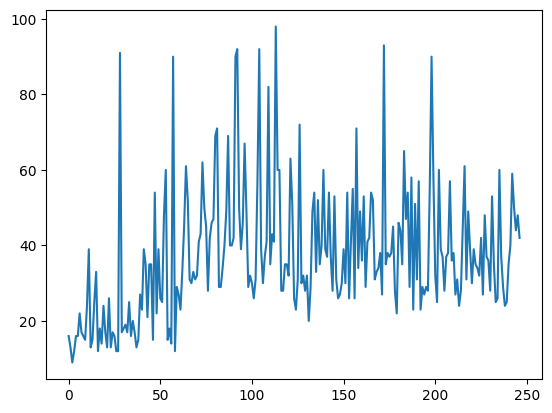

In [123]:
plt.plot(episode_reward_history)

In [40]:
env = gym.make('CartPole-v1')
epsilon = 0

state, _ = env.reset()
trajectory = []
for t in range(100):
    traj = interact_env(state, model, epsilon, n_actions, env)
    trajectory.append(traj)
    if traj['done']:
        break

trajectory

/usr/local/Caskroom/miniforge/base/envs/qml/lib/python3.11/site-packages/pennylane/math/utils.py:227: UserWarning: Contains tensors of types {'autograd', 'tensorflow'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


[{'state': array([[0.00602067, 0.01091631, 0.00542063, 0.0035057 ]], dtype=float32),
  'action': 0,
  'reward': 1.0,
  'next_state': array([[ 0.00623899, -0.18428296,  0.00549074,  0.29789397]],
        dtype=float32),
  'done': False},
 {'state': array([[0.00602067, 0.01091631, 0.00542063, 0.0035057 ]], dtype=float32),
  'action': 0,
  'reward': 1.0,
  'next_state': array([[ 0.00255333, -0.37948275,  0.01144862,  0.5923035 ]],
        dtype=float32),
  'done': False},
 {'state': array([[0.00602067, 0.01091631, 0.00542063, 0.0035057 ]], dtype=float32),
  'action': 0,
  'reward': 1.0,
  'next_state': array([[-0.00503632, -0.57476306,  0.02329469,  0.8885706 ]],
        dtype=float32),
  'done': False},
 {'state': array([[0.00602067, 0.01091631, 0.00542063, 0.0035057 ]], dtype=float32),
  'action': 0,
  'reward': 1.0,
  'next_state': array([[-0.01653158, -0.7701933 ,  0.0410661 ,  1.1884844 ]],
        dtype=float32),
  'done': False},
 {'state': array([[0.00602067, 0.01091631, 0.0054206

In [44]:
def render_episode_as_gif_frames(env_name, actor, max_steps):
    env = gym.make(env_name, render_mode='rgb_array')
    
    state, _ = env.reset()
    
    state = tf.constant(state, dtype=tf.float32)
    screen = env.render()
    images = [Image.fromarray(screen)]
    
    for i in range(1, max_steps+1):
        state = tf.expand_dims(state, 0)
        action_probs = actor(state)
        action = np.argmax(np.squeeze(action_probs))
        
        state, reward, done, _, _ = env.step(action)
        state = tf.constant(state, dtype=tf.float32)
        
        screen = env.render()
        images.append(Image.fromarray(screen))
        
        if done:
            break

    return images

def save_frames_as_gif(frames: list[Image.Image], path: Path, **kwargs):
    frames[1].save(
        path,
        save_all=True,
        append_images=frames[2:],
        optimize=False,
        duration=40,
        loop=0,
        **kwargs,
    )
    
import IPython.display
def display_gif(path: Path) -> IPython.display.DisplayHandle:
    return display(
        IPython.display.Image(
            data=open(path,'rb').read(), format='png'),
        )

/usr/local/Caskroom/miniforge/base/envs/qml/lib/python3.11/site-packages/pennylane/math/utils.py:227: UserWarning: Contains tensors of types {'autograd', 'tensorflow'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


rendering 10 frames to GIF ./images/gym_CartPole.gif


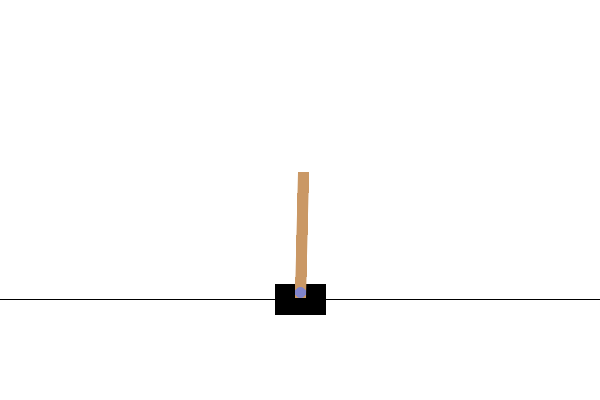

In [45]:
gif_path = './images/gym_CartPole.gif'
frames = render_episode_as_gif_frames('CartPole-v1', model, 100)
print(f"rendering {len(frames)} frames to GIF {gif_path}")
save_frames_as_gif(frames, gif_path)
display_gif(gif_path)